# DSA4213 Assignment 2

### Download dataset

In [1]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
with open("tinyshakespeare.txt", "w", encoding="utf-8") as f:
    f.write(response.text)


### Imports and setup

In [2]:
import time
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

### Dataset preparation

In [12]:

# --- Helper functions ---
def build_vocab(tokens, min_freq=1):
    counter = Counter(tokens)
    vocab = {word: i for i, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    return vocab

def tokenize(text, level="char"):
    if level == "word":
        return text.split()
    else:  # char-level
        return list(text)

# --- Dataset class ---
class TextDataset(Dataset):
    def __init__(self, text, vocab, seq_len=5):
        self.vocab = vocab
        self.itos = list(vocab.keys())
        self.stoi = {w: i for i, w in enumerate(self.itos)}
        self.data = [self.stoi[w] for w in text]
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y

### Build RNN Model

In [7]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers,
                          dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden


### Evaluation Functions

In [8]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

### Training loops

In [ ]:
def train_model(train_loader, val_loader, model, criterion,
                optimizer, epochs=3, clip=1.0, device="cpu"):
    model = model.to(device)
    train_losses, val_losses = [], []
    start_time = time.time()

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, criterion, device)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: Train Loss {avg_train_loss:.3f}, "
              f"Val Loss {avg_val_loss:.3f}, Val PPL {math.exp(avg_val_loss):.3f}")

    total_time = time.time() - start_time
    print(f"\nTraining finished in {total_time:.2f} seconds")

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.savefig("loss_curve.png")
    plt.close()

    return train_losses, val_losses, total_time

### Text generation

In [10]:
def generate_text(model, seed_text, stoi, itos,
                  length=200, temperature=1.0, device="cpu"):
    model.eval()
    input_seq = torch.tensor([stoi.get(ch, 0) for ch in seed_text],
                             dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    output_text = seed_text

    with torch.no_grad():
        for _ in range(length):
            out, hidden = model(input_seq, hidden)
            logits = out[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, 1).item()
            next_char = itos[next_idx]
            output_text += next_char
            input_seq = torch.tensor([[next_idx]], dtype=torch.long).to(device)
    return output_text


### Main runner

In [36]:
if __name__ == "__main__":
    # Configs
    seq_len = 128
    tokenize_level = "word"
    batch_size = 32
    epochs = 3
    lr = 1e-3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # Load data
    with open("tinyshakespeare.txt", "r", encoding="utf-8") as f:
        raw_text = f.read()

    tokens = tokenize(raw_text, tokenize_level)
    vocab = build_vocab(tokens)
    dataset = TextDataset(tokens, vocab, seq_len=seq_len)

    # Split 80/10/10
    n = len(dataset)
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Model, loss, optimizer
    model = RNNModel(len(vocab), embed_size=128, hidden_size=256,
                     num_layers=2, dropout=0.2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    train_losses, val_losses, train_time = train_model(
        train_loader, val_loader, model, criterion, optimizer,
        epochs=epochs, clip=1.0, device=device
    )

    # Test
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):.3f}")

    # Generate samples
    stoi = dataset.stoi
    itos = dataset.itos
    for T in [0.7, 1.0, 1.3]:
        sample = generate_text(model, seed_text="ROMEO:", stoi=stoi, itos=itos,
                               length=300, temperature=T, device=device)
        print(f"\nSample (T={T}):\n{sample}\n")

Using device: cpu


Epoch 1: 100%|██████████| 5064/5064 [1:04:26<00:00,  1.31it/s]


Epoch 1: Train Loss 3.748, Val Loss 1.450, Val PPL 4.262


Epoch 2: 100%|██████████| 5064/5064 [1:00:40<00:00,  1.39it/s]


Epoch 2: Train Loss 1.390, Val Loss 0.658, Val PPL 1.931


Epoch 3: 100%|██████████| 5064/5064 [1:00:32<00:00,  1.39it/s]


Epoch 3: Train Loss 0.915, Val Loss 0.413, Val PPL 1.512

Training finished in 11595.51 seconds

Test Loss: 0.413, Test PPL: 1.512

Sample (T=0.7):
ROMEO:MyLordofGloucester,Ithatmypoorbrother.O,howIdotoheavenYoubreakacrustatall,andyouarewellunderstoodThathorseshallpardonhiminthefield,Wehavemadepeaceworthylords,andhisgreatjustice:Andinrequestofsweetandmyservanthere.Butifyouseethisworthylife,nostaintheairAndnotherbeautynornoneelsetheydoseemuponyourfather'sprayerAndindevotionspendtheirlossWhichwearesurebyanddrinkingfindme,AndClarenceandatlove,sobothasthemannerandthemoveablesWhereofwemaybeadmittedEnvironedeverydayinhimseemtobe,forhismind.ROMEO:Thenneverthatthekingisdead.LEONTES:WhoshallhinderforthisdaysnorsetMyfriend,Hewillstandalone;Thoughreadysoearlyinhismistress'GREMIO:ButsinceweheardofgeneralShouldhavetoldhersontoyourcrown!KINGRICHARDII:WethankmefromtheplaceisheWillawaytherightanddothcurstwithus.QUEENMARGARET:SonameIhope,sheis,anddothehiretheirwickedandisfullofdread:Yecannotreasonthatt

Model, vocab, and evaluation saved in C:\Users\valer\Desktop\New folder\RNN_base


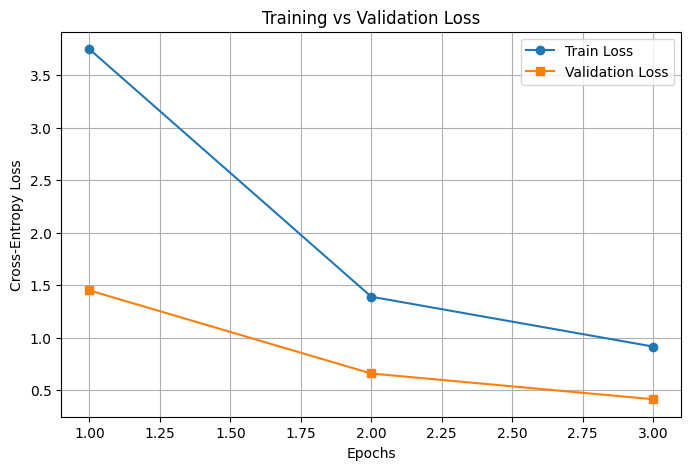

In [ ]:
import torch
import os
import math
import json

# Save everything
out_dir = r"C:\Users\valer\Desktop\New folder\RNN_base"
os.makedirs(out_dir, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(out_dir, "rnn_model.pt"))

# Save vocab
torch.save({"stoi": dataset.stoi, "itos": dataset.itos}, os.path.join(out_dir, "vocab.pt"))

# Save evaluation results
results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_time_sec": train_time,
    "test_loss": test_loss,
    "test_perplexity": math.exp(test_loss),
}
with open(os.path.join(out_dir, "evaluation.json"), "w") as f:
    json.dump(results, f, indent=4)

print(f"Model, vocab, and evaluation saved in {out_dir}")

# Load evaluation results
with open(r"C:\Users\valer\Desktop\New folder\RNN_base\evaluation.json", "r") as f:
    results = json.load(f)

train_losses = results["train_losses"]
val_losses = results["val_losses"]

# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(r"C:\Users\valer\Desktop\New folder\RNN_base\loss_curve.png")
plt.show()


### Main runner Dropout = 0.0

In [18]:
if __name__ == "__main__":
    # Configs
    seq_len = 128
    tokenize_level = "word"
    batch_size = 32
    epochs = 3
    lr = 1e-3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # Load data
    with open("tinyshakespeare.txt", "r", encoding="utf-8") as f:
        raw_text = f.read()

    tokens = tokenize(raw_text, tokenize_level)
    vocab = build_vocab(tokens)
    dataset = TextDataset(tokens, vocab, seq_len=seq_len)

    # Split 80/10/10
    n = len(dataset)
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Model, loss, optimizer
    model = RNNModel(len(vocab), embed_size=128, hidden_size=256,
                     num_layers=2, dropout=0.0)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    train_losses, val_losses, train_time = train_model(
        train_loader, val_loader, model, criterion, optimizer,
        epochs=epochs, clip=1.0, device=device
    )

    # Test
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):.3f}")

    # Generate samples
    stoi = dataset.stoi
    itos = dataset.itos
    for T in [0.7, 1.0, 1.3]:
        sample = generate_text(model, seed_text="ROMEO:", stoi=stoi, itos=itos,
                               length=300, temperature=T, device=device)
        print(f"\nSample (T={T}):\n{sample}\n")

Using device: cpu


Epoch 1: 100%|██████████| 5064/5064 [1:06:15<00:00,  1.27it/s]


Epoch 1: Train Loss 2.894, Val Loss 0.597, Val PPL 1.817


Epoch 2: 100%|██████████| 5064/5064 [1:11:05<00:00,  1.19it/s]


Epoch 2: Train Loss 0.371, Val Loss 0.294, Val PPL 1.342


Epoch 3: 100%|██████████| 5064/5064 [1:01:44<00:00,  1.37it/s]


Epoch 3: Train Loss 0.249, Val Loss 0.256, Val PPL 1.292

Training finished in 12441.03 seconds

Test Loss: 0.255, Test PPL: 1.291

Sample (T=0.7):
ROMEO:Omymisery,isfreewithherTowife?MOPSA:Prayyou,leavetokinglysepulchres;andthou,WhichMaycallyouMarcius.WhatsaymykindPOMPEY:IfwhatmostmantotwodayshewoninoneherForthismanofthequeenandhisheadAsthere,Ifear,nottillKingRichardtobeloudweather;Besides,thisplaceunderyourinjuries,Andsigh'dthemattheconsecratedfountAleaguebelowthecity;andfromthence,Bycoldgradationandwell-balancedform,WeshallproceedwithAngelo.Provost:Hereisthehead;I'llcarryitmyself.DUKEVINCENTIO:Convenientisit.Makeaswiftreturn;ForIwouldcommunewithyouofsuchthingsThatwantnoearbutyours.Provost:I'llmakeallspeed.ISABELLA:DUKEVINCENTIO:ThetongueofIsabel.She'scometohimthanmineownyouthandlivinglies;ButshallIgotobringyoutotheseFrommyownfoesmustwithyouthepardonThanmuchandinourbehalfandinwarmHiseyeWhosedoublebosomsseemtowearoneheart,Whosesonandmade,orastheydopastme.QUEENELIZABETH:Mygoodsir,Iwoul

Model, vocab, and evaluation saved in C:\Users\valer\Desktop\New folder\RNN_base


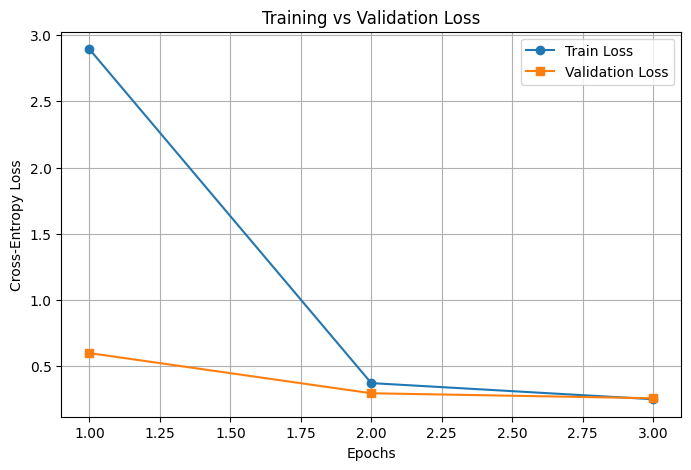

In [33]:
import torch
import os
import math
import json

# Save everything
out_dir = r"C:\Users\valer\Desktop\New folder\RNN_base"
os.makedirs(out_dir, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(out_dir, "rnn_model_dropout.pt"))

# Save vocab
torch.save({"stoi": dataset.stoi, "itos": dataset.itos}, os.path.join(out_dir, "vocab_dropout.pt"))

# Save evaluation results
results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_time_sec": train_time,
    "test_loss": test_loss,
    "test_perplexity": math.exp(test_loss),
}
with open(os.path.join(out_dir, "evaluation_dropout.json"), "w") as f:
    json.dump(results, f, indent=4)

print(f"Model, vocab, and evaluation saved in {out_dir}")

# Load evaluation results
with open(r"C:\Users\valer\Desktop\New folder\RNN_base\evaluation_dropout.json", "r") as f:
    results = json.load(f)

train_losses = results["train_losses"]
val_losses = results["val_losses"]

# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(r"C:\Users\valer\Desktop\New folder\RNN_base\loss_curve_dropout.png")
plt.show()


### Main runner Character Tokenization

In [34]:
if __name__ == "__main__":
    # Configs
    seq_len = 256               
    tokenize_level = "char"      
    batch_size = 32
    epochs = 3
    lr = 1e-3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # Load data
    with open("tinyshakespeare.txt", "r", encoding="utf-8") as f:
        raw_text = f.read()

    tokens = tokenize(raw_text, tokenize_level)   
    vocab = build_vocab(tokens)
    dataset = TextDataset(tokens, vocab, seq_len=seq_len)

    # Split 80/10/10
    n = len(dataset)
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Model, loss, optimizer
    model = RNNModel(len(vocab), embed_size=128, hidden_size=256,
                     num_layers=2, dropout=0.2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    train_losses, val_losses, train_time = train_model(
        train_loader, val_loader, model, criterion, optimizer,
        epochs=epochs, clip=1.0, device=device
    )

    # Test
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):.3f}")

    # Generate samples
    stoi = dataset.stoi
    itos = dataset.itos
    for T in [0.7, 1.0, 1.3]:
        sample = generate_text(model, seed_text="ROMEO:", stoi=stoi, itos=itos,
                               length=300, temperature=T, device=device)
        print(f"\nSample (T={T}):\n{sample}\n")


Using device: cpu


Epoch 1: 100%|██████████| 27879/27879 [41:38<00:00, 11.16it/s]


Epoch 1: Train Loss 1.344, Val Loss 1.230, Val PPL 3.420


Epoch 2: 100%|██████████| 27879/27879 [43:16<00:00, 10.74it/s]


Epoch 2: Train Loss 1.293, Val Loss 1.222, Val PPL 3.393


Epoch 3: 100%|██████████| 27879/27879 [46:15<00:00, 10.04it/s]


Epoch 3: Train Loss 1.287, Val Loss 1.218, Val PPL 3.380

Training finished in 8190.85 seconds

Test Loss: 1.218, Test PPL: 3.379

Sample (T=0.7):
ROMEO:
I can fall
With that I return to be frail the dead friends,
Should not have most warm on me by your complexion is here?

Second Keeper:
Sir, my lord,
And hence accused to my life,
And death is lack, in this earth.

First Murderer:
Why, Kate, behold him more than I have allier,
To say your remembran


Sample (T=1.0):
ROMEO:
Unfection of Glouce, for she was 'manine this support no rest,' the title before you, Camillo that sendry securer
Thy blessed orderers.

AUFIDIUS:
Amiss you, lords: for thy mercy and one statue, and with the clouds of so; like born.
All I prove cannot speak not doth swear, hear again of Hornous sev


Sample (T=1.3):
ROMEO:
First, wounds shew, as ahterwain.
Procirot, if I do's thought sweet, Pothine cubbours, forbear him, go wiutchills
That Herries in lion court's dust removed to creatures:
If he have close specience

Model, vocab, and evaluation saved in C:\Users\valer\Desktop\New folder\RNN_base


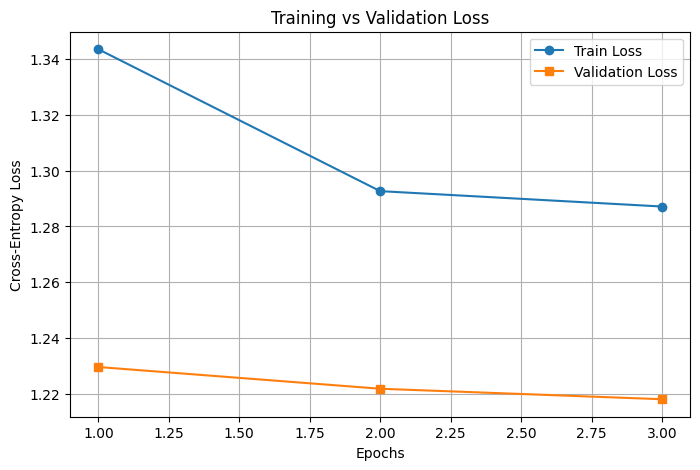

In [35]:
import torch
import os
import math
import json

# Save everything
out_dir = r"C:\Users\valer\Desktop\New folder\RNN_base"
os.makedirs(out_dir, exist_ok=True)

# Save model weights
torch.save(model.state_dict(), os.path.join(out_dir, "rnn_model_char.pt"))

# Save vocab
torch.save({"stoi": dataset.stoi, "itos": dataset.itos}, os.path.join(out_dir, "vocab_char.pt"))

# Save evaluation results
results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_time_sec": train_time,
    "test_loss": test_loss,
    "test_perplexity": math.exp(test_loss),
}
with open(os.path.join(out_dir, "evaluation_char.json"), "w") as f:
    json.dump(results, f, indent=4)

print(f"Model, vocab, and evaluation saved in {out_dir}")

# Load evaluation results
with open(r"C:\Users\valer\Desktop\New folder\RNN_base\evaluation_char.json", "r") as f:
    results = json.load(f)

train_losses = results["train_losses"]
val_losses = results["val_losses"]

# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(r"C:\Users\valer\Desktop\New folder\RNN_base\loss_curve_char.png")
plt.show()


### Load data

In [5]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
with open("tinyshakespeare.txt", "w", encoding="utf-8") as f:
    f.write(response.text)

with open("tinyshakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Char-level tokenization
tokens = list(text)
vocab = sorted(set(tokens))
vocab_size = len(vocab)

stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
data = [stoi[ch] for ch in tokens]

print(f"Dataset size: {len(data)} characters")
print(f"Vocabulary size: {vocab_size}")

Dataset size: 1115394 characters
Vocabulary size: 65


### Dataset Preparation

In [6]:
class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y


### Build LSTM Model

In [7]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

### Evaluation function

In [8]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

### Training

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, clip=1.0):
    train_losses, val_losses = [], []
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for x, y in progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, criterion, device)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.3f}, "
              f"Val Loss={avg_val_loss:.3f}, Val PPL={math.exp(avg_val_loss):.3f}")

    return train_losses, val_losses

### Main runner

In [ ]:
if __name__ == "__main__":
    seq_len = 128
    batch_size = 32
    embed_size = 128
    hidden_size = 256
    num_layers = 2
    dropout = 0.2
    lr = 1e-3
    epochs = 3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    dataset = TextDataset(data, seq_len)

    # 80/10/10 split
    n = len(dataset)
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                           criterion, optimizer, epochs, device)

    # Test set evaluation
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):.3f}")



Using device: cpu


Epoch 1/3: 100%|██████████| 27882/27882 [45:26<00:00, 10.23it/s, loss=1.1] 


Epoch 1: Train Loss=1.215, Val Loss=1.011, Val PPL=2.749


Epoch 2/3: 100%|██████████| 27882/27882 [31:38<00:00, 14.69it/s, loss=1.05] 


Epoch 2: Train Loss=1.067, Val Loss=0.948, Val PPL=2.582


Epoch 3/3: 100%|██████████| 27882/27882 [31:21<00:00, 14.82it/s, loss=1.01] 


Epoch 3: Train Loss=1.037, Val Loss=0.919, Val PPL=2.507

Final Test Loss: 0.919, Test PPL: 2.508


NameError: name 'os' is not defined

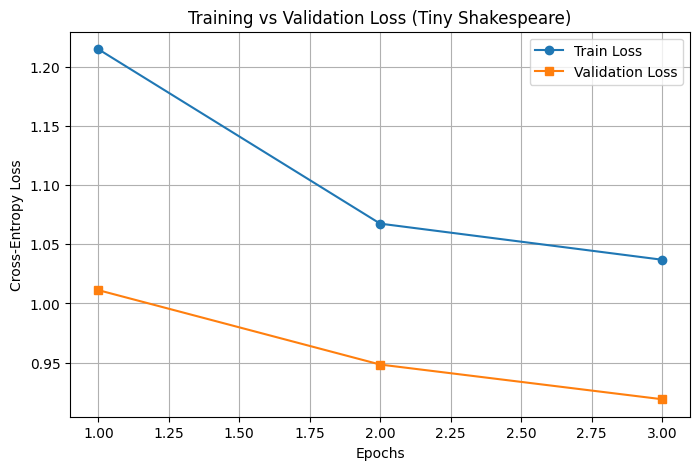

In [14]:
import os  
import json
 # Save everything
out_dir = r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare"
os.makedirs(out_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(out_dir, "lstm_model.pt"))
torch.save({"stoi": stoi, "itos": itos}, os.path.join(out_dir, "vocab.pt"))

results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss,
        "test_perplexity": math.exp(test_loss)
    }
with open(os.path.join(out_dir, "evaluation.json"), "w") as f:
        json.dump(results, f, indent=4)

 # Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Validation Loss (Tiny Shakespeare)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(out_dir, "loss_curve.png"))
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

# === 1. Define Model Class (must match training) ===
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

# === 2. Load Model & Vocab ===
out_dir = r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare"

# Load vocab
vocab_data = torch.load(os.path.join(out_dir, "vocab_char.pt"))
stoi, itos = vocab_data["stoi"], vocab_data["itos"]
vocab_size = len(stoi)

# Model config (must match training)
embed_size = 128
hidden_size = 256
num_layers = 2
dropout = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Rebuild model and load weights
model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load(os.path.join(out_dir, "lstm_model_char.pt"), map_location=device))
model.eval()

print("✅ Loaded saved LSTM model and vocab")

# === 3. Text Generation Function ===
def generate_text(model, start_text, stoi, itos, length=300, temperature=1.0, device="cpu"):
    model.eval()
    input_ids = torch.tensor([stoi[ch] for ch in start_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(start_text)
    hidden = None

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_ids, hidden)
            logits = output[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            next_char = itos[next_id]
            generated.append(next_char)
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

    return ''.join(generated)

# === 4. Generate Samples from Saved Model ===
for T in [0.7, 1.0, 1.3]:
    sample = generate_text(model, start_text="ROMEO:", stoi=stoi, itos=itos,
                           length=300, temperature=T, device=device)
    print(f"\n--- Sample (T={T}) ---\n{sample}\n")


C:\Users\valer\AppData\Local\Temp\ipykernel_20388\1000235112.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab_data = torch.load(os.path.join(out_dir, "vocab_char.p

✅ Loaded saved LSTM model and vocab

--- Sample (T=0.7) ---
ROMEO:

ANGELO:
Pardon, peace!
To see the people.

SICINIUS:
The rag is not a friend.

CLAUDIO:
Thus is this man, whom I may be hard from a devil
With builds that thought on thee.

AUTOLYCUS:
A shall buy that this contempled with the readiest
a stars and what is short. Would he shall be the
counterfeit of


--- Sample (T=1.0) ---
ROMEO:
That's so qualified. Where's Romeo's rather, to you?
What father are these? are thy tongue?

BUCKINGHAM:
My lord, that my wife is spirt.

HENRY BOLINGBROKE:
Best falls, that I may be gone to woo my own.

ISABELLA:
You were no simple comfort thread you!

MENENIUS:
It is the morniness of another.

VO


--- Sample (T=1.3) ---
ROMEO:
I have a jest a divine; for they--natural,
with best haste. Nay, no, go me: he's dead, and rise
To say, Tybalt.

KATHARINA:
Hold, withinded at Bifeso? wherefore weeps he?
Go, bear! thou diest to him! Help my dark past,
And most King for sweetness.

MIRANDA:
O, you fail

### Main runner dropout 0.0

In [15]:
if __name__ == "__main__":
    seq_len = 128
    batch_size = 32
    embed_size = 128
    hidden_size = 256
    num_layers = 2
    dropout = 0.0
    lr = 1e-3
    epochs = 3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    dataset = TextDataset(data, seq_len)

    # 80/10/10 split
    n = len(dataset)
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                           criterion, optimizer, epochs, device)

    # Test set evaluation
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):.3f}")



Using device: cpu


Epoch 1/3: 100%|██████████| 27882/27882 [30:19<00:00, 15.32it/s, loss=0.808]


Epoch 1: Train Loss=1.037, Val Loss=0.799, Val PPL=2.222


Epoch 2/3: 100%|██████████| 27882/27882 [31:02<00:00, 14.97it/s, loss=0.679]


Epoch 2: Train Loss=0.721, Val Loss=0.673, Val PPL=1.961


Epoch 3/3: 100%|██████████| 27882/27882 [31:04<00:00, 14.95it/s, loss=0.631]


Epoch 3: Train Loss=0.648, Val Loss=0.630, Val PPL=1.877

Final Test Loss: 0.629, Test PPL: 1.876


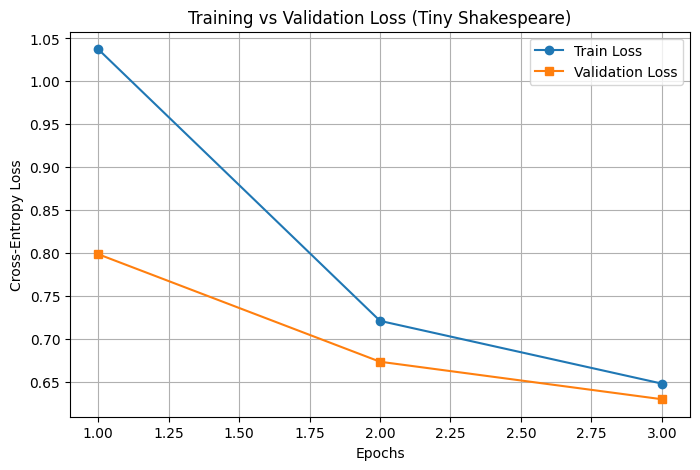

In [17]:
import os  
import json
 # Save everything
out_dir = r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare"
os.makedirs(out_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(out_dir, "lstm_model_dropout.pt"))
torch.save({"stoi": stoi, "itos": itos}, os.path.join(out_dir, "vocab_dropout.pt"))

results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss,
        "test_perplexity": math.exp(test_loss)
    }
with open(os.path.join(out_dir, "evaluation_dropout.json"), "w") as f:
        json.dump(results, f, indent=4)

 # Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Validation Loss (Tiny Shakespeare)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(out_dir, "loss_curve.png"))
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import json

# 1. Define Model Class 

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden


# 2. Load Model & Vocab

out_dir = r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare"

# Load vocab mappings
vocab_data = torch.load(os.path.join(out_dir, "vocab.pt"))
stoi, itos = vocab_data["stoi"], vocab_data["itos"]
vocab_size = len(stoi)

# Model config 
embed_size = 128
hidden_size = 256
num_layers = 2
dropout = 0.2

# Initialize model and load weights
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load(os.path.join(out_dir, "lstm_model.pt"), map_location=device))
model.eval()

print("Model and vocab loaded successfully")


# 3. Text Generation Function

def generate_text(model, start_text, stoi, itos, length=300, temperature=1.0, device="cpu"):
    model.eval()
    input_ids = torch.tensor([stoi[ch] for ch in start_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(start_text)
    hidden = None

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_ids, hidden)
            logits = output[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            next_char = itos[next_id]
            generated.append(next_char)
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

    return ''.join(generated)


# 4. Generate Samples

for T in [0.7, 1.0, 1.3]:
    sample = generate_text(model, start_text="ROMEO:", stoi=stoi, itos=itos,
                           length=300, temperature=T, device=device)
    print(f"\n--- Sample (T={T}) ---\n{sample}\n")


C:\Users\valer\AppData\Local\Temp\ipykernel_20388\845731915.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab_data = torch.load(os.path.join(out_dir, "vocab.pt"))
C

Model and vocab loaded successfully

--- Sample (T=0.7) ---
ROMEO:
I think 'twere but a pack of meat,
The spires and grace and fresh steal of them;
No usures presently, he is not there.
Farewell, my lord, be gone.

PETRUCHIO:
Signior Baptista, is it such a humour,
That we seem to love, and see that time let me see;
It is a pre-onience that I have,
Too long and her


--- Sample (T=1.0) ---
ROMEO:
He hath bold and leave unto his readness,
Sejussed upon this hand: wherefore was my husband?
Or, away! dampare with haste you did I.
No, no! why, no shape is after behelves;
A vengean-wives, which is a sensible:
I do resemble it, and not the sea
For covert with a cale temples of those
So cursed by 


--- Sample (T=1.3) ---
ROMEO:
Yes, something shall; say you, wit is dead?

Second Murderer:
Where is so ballain?

Pursuing:
Sir, heep forsworn, wise.

BIANCA:
If your grandat presently?
Good madam, favour, adieu! for meaner tashes,
Parcel whose blaceming years since the worsw
And Hereford slay, tha

### Main runner char tokenization

Dataset size: 1115394 characters
Vocab size: 65
Using device: cpu


Epoch 1/3: 100%|██████████| 13941/13941 [27:06<00:00,  8.57it/s, loss=1.12]


Epoch 1: Train Loss=1.253, Val Loss=1.020, Val PPL=2.774


Epoch 2/3: 100%|██████████| 13941/13941 [29:20<00:00,  7.92it/s, loss=1.04] 


Epoch 2: Train Loss=1.061, Val Loss=0.932, Val PPL=2.539


Epoch 3/3: 100%|██████████| 13941/13941 [32:05<00:00,  7.24it/s, loss=1.04] 


Epoch 3: Train Loss=1.021, Val Loss=0.897, Val PPL=2.452

Final Test Loss: 0.898, Test PPL: 2.454


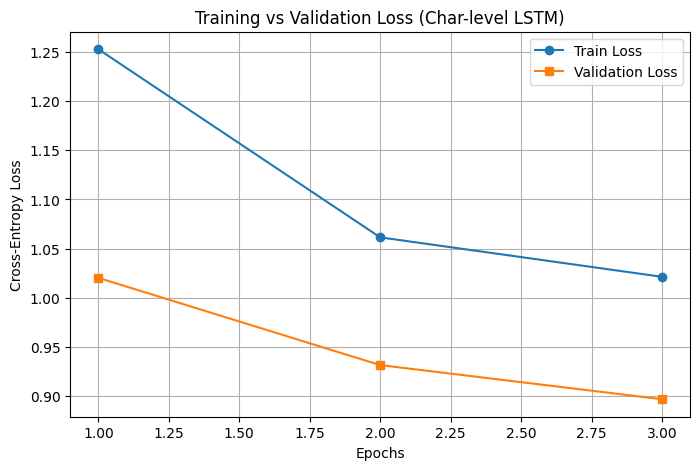

In [19]:
import requests, os, json, math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Char-level tokenization
tokens = list(text)
vocab = sorted(set(tokens))
vocab_size = len(vocab)

stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
data = [stoi[ch] for ch in tokens]

print(f"Dataset size: {len(data)} characters")
print(f"Vocab size: {vocab_size}")


# 2. Dataset

class TextDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y


# 3. Model (LSTM)

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden


# 4. Training & Eval

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out, _ = model(x)
            loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, clip=1.0):
    train_losses, val_losses = [], []
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for x, y in progress:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, criterion, device)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.3f}, "
              f"Val Loss={avg_val_loss:.3f}, Val PPL={math.exp(avg_val_loss):.3f}")

    return train_losses, val_losses


# 5. Main

if __name__ == "__main__":
    # Configs (assignment)
    seq_len = 128
    batch_size = 64
    embed_size = 128
    hidden_size = 256
    num_layers = 2
    dropout = 0.2
    lr = 1e-3
    epochs = 3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    dataset = TextDataset(data, seq_len)

    # 80/10/10 split
    n = len(dataset)
    train_size = int(0.8 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                           criterion, optimizer, epochs, device)

    # Test set evaluation
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Loss: {test_loss:.3f}, Test PPL: {math.exp(test_loss):.3f}")


    # Save results
 
    out_dir = r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare"
    os.makedirs(out_dir, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(out_dir, "lstm_model_char.pt"))
    torch.save({"stoi": stoi, "itos": itos}, os.path.join(out_dir, "vocab_char.pt"))

    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss,
        "test_perplexity": math.exp(test_loss)
    }
    with open(os.path.join(out_dir, "evaluation_char.json"), "w") as f:
        json.dump(results, f, indent=4)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Training vs Validation Loss (Char-level LSTM)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "loss_curve_char.png"))
    plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

# === 1. Define Model Class (same as training) ===
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

# === 2. Load Model & Vocab ===
out_dir = r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare"

# Load vocab
vocab_data = torch.load(os.path.join(out_dir, "vocab_char.pt"))
stoi, itos = vocab_data["stoi"], vocab_data["itos"]
vocab_size = len(stoi)

# Configs (must match training)
embed_size = 128
hidden_size = 256
num_layers = 2
dropout = 0.2

device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
model.load_state_dict(torch.load(os.path.join(out_dir, "lstm_model_char.pt"), map_location=device))
model.eval()

print("✅ Model loaded successfully")

# === 3. Generate Text Function ===
def generate_text(model, start_text, stoi, itos, length=300, temperature=1.0, device="cpu"):
    model.eval()
    input_ids = torch.tensor([stoi[ch] for ch in start_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = list(start_text)
    hidden = None

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_ids, hidden)
            logits = output[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            next_char = itos[next_id]
            generated.append(next_char)
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

    return ''.join(generated)

# === 4. Generate Samples ===
for T in [0.7, 1.0, 1.3]:
    sample = generate_text(model, start_text="ROMEO:", stoi=stoi, itos=itos,
                           length=300, temperature=T, device=device)
    print(f"\n--- Sample (T={T}) ---\n{sample}\n")


C:\Users\valer\AppData\Local\Temp\ipykernel_20388\4124891485.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vocab_data = torch.load(os.path.join(out_dir, "vocab_char.p

✅ Model loaded successfully

--- Sample (T=0.7) ---
ROMEO:
Sir, I could not so turn my proud countenance,
To seem the man that lovest them to them as hanged
To purk it in the name of God and sight:
And this is this worthy prison, so loved a fear.

ROMEO:
Ay, by the greatest came of the present pardon.

DUKE VINCENTIO:
Good prince:
How fares our loving life


--- Sample (T=1.0) ---
ROMEO:
If you turn away, I say, in our pitch, muting
Than fair mistress, and condemned town,
So many letters are quickly, when reap-snip,
Of our damned gates of libewity.
Ah, what should be stand not? But, marry,--fain with grief,
To heaven may our fresh promoty and strength.
ourself, with knocks as ann g


--- Sample (T=1.3) ---
ROMEO:
O; I beseech you, marry, you must
would be here
Some vengeang in Most warrant himself, and evys
his cunning! I'll not drrip at eight.

NURSHES:
Gallow! which Clifford fairly asly, pluck this?
Dock hit myself, Kate, that a murder, he's fair;
Or I'larry Quict-maning over Claudio

### Comparison

In [26]:
import json
import matplotlib.pyplot as plt
import os

# === Load Results ===
with open(r"C:\Users\valer\Desktop\New folder\LSTM_shakespeare\evaluation.json", "r") as f:
    lstm_results = json.load(f)

with open(r"C:\Users\valer\Desktop\New folder\RNN_base\evaluation.json", "r") as f:
    rnn_results = json.load(f)

# Extract losses
lstm_train = lstm_results["train_losses"]
lstm_val = lstm_results["val_losses"]
rnn_train = rnn_results["train_losses"]
rnn_val = rnn_results["val_losses"]

# Epoch indices
epochs_lstm = range(1, len(lstm_train) + 1)
epochs_rnn = range(1, len(rnn_train) + 1)

# Save folder
out_dir = r"C:\Users\valer\Desktop\New folder"

# --- Training Loss Comparison ---
plt.figure(figsize=(8,5))
plt.plot(epochs_rnn, rnn_train, label="RNN Train", marker="o")
plt.plot(epochs_lstm, lstm_train, label="LSTM Train", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss: RNN vs LSTM")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(out_dir, "train_loss_comparison.png"))
plt.close()

# --- Validation Loss Comparison ---
plt.figure(figsize=(8,5))
plt.plot(epochs_rnn, rnn_val, label="RNN Val", marker="o", linestyle="--")
plt.plot(epochs_lstm, lstm_val, label="LSTM Val", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Validation Loss: RNN vs LSTM")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(out_dir, "val_loss_comparison.png"))
plt.close()

print(f"Saved comparison plots to {out_dir}")


Saved comparison plots to C:\Users\valer\Desktop\New folder
